In [ ]:
from google.colab import drive
import zipfile
import os

In [ ]:
drive.mount('/content/drive')

zip_path = '/content/drive/MyDrive/archive.zip'
extract_path = 'camvid'

Mounted at /content/drive


In [ ]:
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [ ]:
for root, dirs, files in os.walk(extract_path):
    print(root, len(files), "files")

camvid 0 files
camvid/CamVid 1 files
camvid/CamVid/val_labels 100 files
camvid/CamVid/val 100 files
camvid/CamVid/train_labels 369 files
camvid/CamVid/test_labels 232 files
camvid/CamVid/test 232 files
camvid/CamVid/train 369 files


In [ ]:
num_classes = 3

In [ ]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import torchvision.transforms as transforms
import torch
import torch.nn as nn

In [ ]:
CLASS_RGB_MAP = {
    (64, 0, 64): 0,     # Car
    (128, 0, 0): 1,     # Building
    (128, 64, 128): 2   # Road
}

In [ ]:
def map_rgb_classes(mask):
    h, w, _ = mask.shape
    class_mask = np.zeros((h, w), dtype=np.int64)
    for rgb, class_idx in CLASS_RGB_MAP.items():
        match = np.all(mask == rgb, axis=-1)
        class_mask[match] = class_idx
    return class_mask

In [ ]:
class CamVidDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.images = sorted(os.listdir(image_dir))
        self.labels = sorted(os.listdir(label_dir))
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.label_dir, self.labels[idx])

        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)

        if self.transform:
            img = self.transform(img)
            mask = np.array(mask.resize((128, 128), Image.NEAREST))
            if mask.ndim == 3:
                mask = map_rgb_classes(mask)
            else:
                raise ValueError("Expected RGB mask with 3 channels.")
            mask = torch.as_tensor(mask, dtype=torch.long)

        return img, mask

In [ ]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

train_dataset = CamVidDataset("camvid/CamVid/train", "camvid/CamVid/train_labels", transform=transform)
val_dataset = CamVidDataset("camvid/CamVid/val", "camvid/CamVid/val_labels", transform=transform)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

In [ ]:
class UNet(nn.Module):
    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1), nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(64, num_classes, 1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = UNet(num_classes=num_classes)

In [ ]:
checkpoint_path = "/content/drive/MyDrive/unet_epoch1000.pth"
if os.path.exists(checkpoint_path):
    model.load_state_dict(torch.load(checkpoint_path))
    print(f"Loaded checkpoint from {checkpoint_path}")

Loaded checkpoint from /content/drive/MyDrive/unet_epoch1000.pth


In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(DEVICE)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

print("Checking dataset labels for unmapped values...")
for _, mask in train_dataset:
    vals = torch.unique(mask)
    if (vals >= num_classes).any():
        print(f"[ERROR] Found invalid class value(s): {vals.tolist()}")
        raise ValueError("Dataset contains labels outside expected class range.")
print("All mask values are within range.")

Checking dataset labels for unmapped values...
All mask values are within range.


In [ ]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

In [ ]:
start_epoch = 1000
total_epochs = 1050
for epoch in range(start_epoch, total_epochs):
    train_correct = 0
    train_total = 0
    model.train()
    train_total_loss = 0
    for imgs, masks in train_loader:
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        outputs = model(imgs)
        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_total_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        train_correct += (preds == masks).sum().item()
        train_total += masks.numel()

    model.eval()
    val_total_loss = 0
    val_correct = 0
    val_total = 0
    train_acc = train_correct / train_total
    train_accuracies.append(train_acc)
    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
            outputs = model(imgs)
            loss = criterion(outputs, masks)
            val_total_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            val_correct += (preds == masks).sum().item()
            val_total += masks.numel()
    val_acc = val_correct / val_total
    val_accuracies.append(val_acc)
    print(f"Epoch {epoch+1}, Train Loss: {train_total_loss:.4f}, Val Loss: {val_total_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

    if (epoch + 1) % 50 == 0:
        checkpoint_path = f"/content/drive/MyDrive/unet_epoch{epoch+1}.pth"
        torch.save(model.state_dict(), checkpoint_path)
        print(f"Saved checkpoint to {checkpoint_path}")
    train_losses.append(train_total_loss)
    val_losses.append(val_total_loss)

Epoch 1001, Train Loss: 31.0513, Val Loss: 8.1909, Train Acc: 0.8562, Val Acc: 0.8639
Epoch 1002, Train Loss: 30.6940, Val Loss: 8.4016, Train Acc: 0.8596, Val Acc: 0.8575
Epoch 1003, Train Loss: 30.7978, Val Loss: 8.2484, Train Acc: 0.8574, Val Acc: 0.8600
Epoch 1004, Train Loss: 30.4426, Val Loss: 8.3063, Train Acc: 0.8598, Val Acc: 0.8621
Epoch 1005, Train Loss: 31.0880, Val Loss: 8.6078, Train Acc: 0.8560, Val Acc: 0.8557
Epoch 1006, Train Loss: 31.1296, Val Loss: 8.2497, Train Acc: 0.8561, Val Acc: 0.8631
Epoch 1007, Train Loss: 31.0640, Val Loss: 8.3488, Train Acc: 0.8566, Val Acc: 0.8609
Epoch 1008, Train Loss: 30.8903, Val Loss: 8.3602, Train Acc: 0.8573, Val Acc: 0.8573
Epoch 1009, Train Loss: 30.4079, Val Loss: 8.1856, Train Acc: 0.8597, Val Acc: 0.8632
Epoch 1010, Train Loss: 30.9364, Val Loss: 8.3037, Train Acc: 0.8580, Val Acc: 0.8603
Epoch 1011, Train Loss: 30.6773, Val Loss: 8.4329, Train Acc: 0.8585, Val Acc: 0.8594
Epoch 1012, Train Loss: 30.5208, Val Loss: 8.2885, Tra

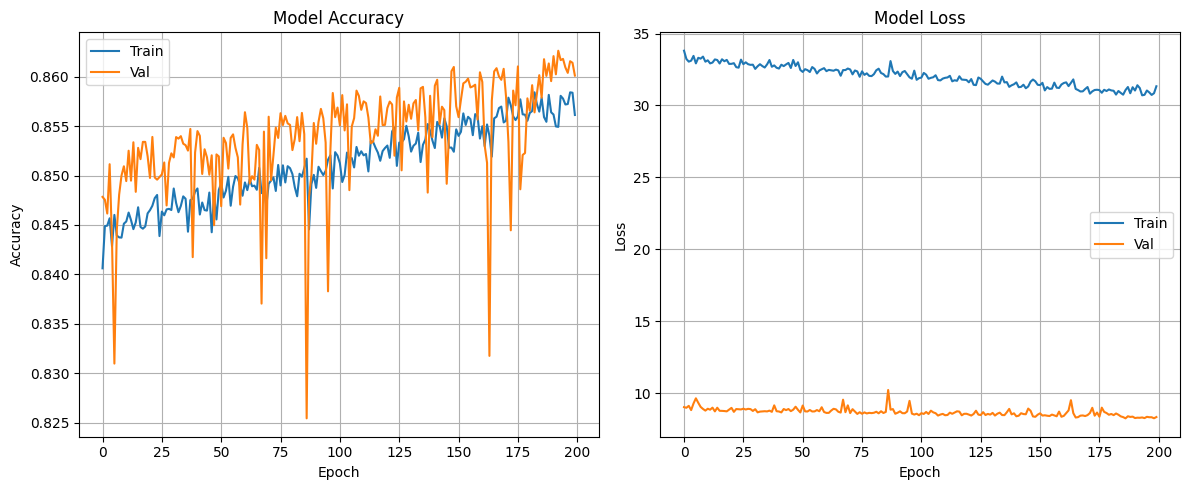

In [ ]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].plot(train_accuracies, label='Train')
axs[0].plot(val_accuracies, label='Val')
axs[0].set_title("Model Accuracy")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Accuracy")
axs[0].legend()
axs[0].grid(True)

axs[1].plot(train_losses, label='Train')
axs[1].plot(val_losses, label='Val')
axs[1].set_title("Model Loss")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Loss")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import f1_score
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for imgs, masks in val_loader:
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        outputs = model(imgs)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy().flatten())
        all_labels.extend(masks.cpu().numpy().flatten())

micro_f1 = f1_score(all_labels, all_preds, average='micro', zero_division=1)
macro_f1 = f1_score(all_labels, all_preds, average='macro', zero_division=1)
dice_score = f1_score(all_labels, all_preds, average='macro', zero_division=1)

print(f"Dice Score (macro F1): {dice_score:.4f}")
print(f"Micro-F1 Score: {micro_f1:.4f}")
print(f"Macro-F1 Score: {macro_f1:.4f}")

Dice Score (macro F1): 0.8554
Micro-F1 Score: 0.8601
Macro-F1 Score: 0.8554


In [ ]:
COLOR_PALETTE = {
    0: (100, 100, 255),   # Car - blue
    1: (160, 100, 100),   # Building - red
    2: (100, 255, 100)    # Road - green
}

def decode_segmap(mask):
    h, w = mask.shape
    rgb = np.zeros((h, w, 3), dtype=np.uint8)
    for class_idx, color in COLOR_PALETTE.items():
        rgb[mask == class_idx] = color
    return rgb

Visualizing random predictions...


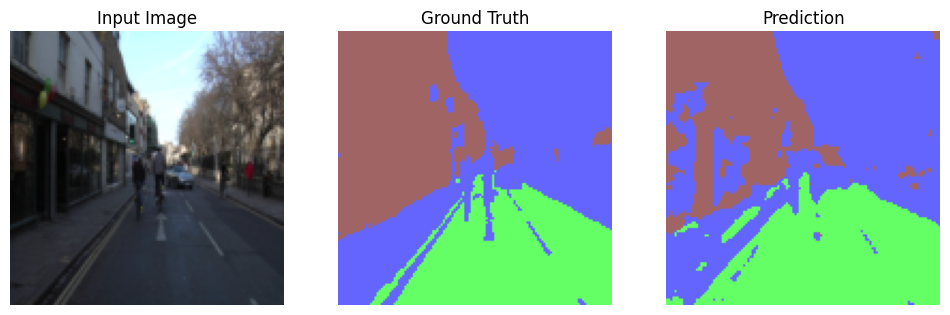

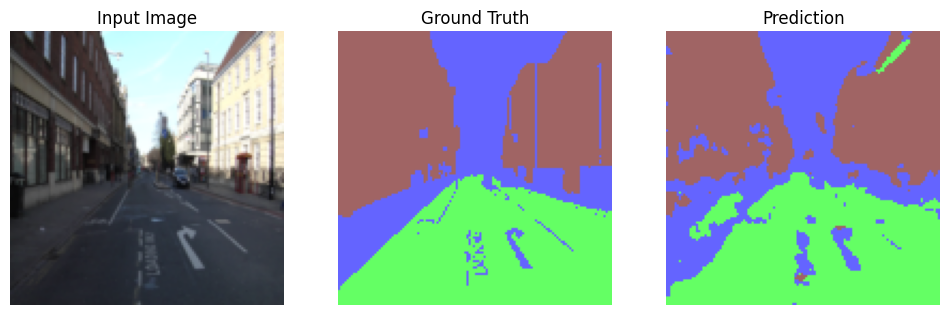

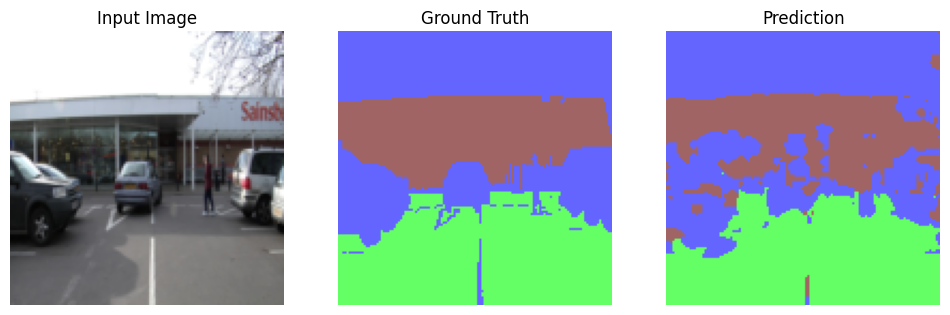

In [ ]:
import random
model.eval()
print("Visualizing random predictions...")
with torch.no_grad():
    for _ in range(3):
        idx = random.randint(0, len(val_dataset) - 1)
        img, mask = val_dataset[idx]
        img_batch = img.unsqueeze(0).to(DEVICE)
        output = model(img_batch)
        pred = torch.argmax(output, dim=1)[0].cpu().numpy()

        image_np = img.permute(1, 2, 0).numpy()
        label_np = mask.numpy()

        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.title("Input Image")
        plt.imshow(image_np)
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.title("Ground Truth")
        plt.imshow(decode_segmap(label_np))
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.title("Prediction")
        plt.imshow(decode_segmap(pred))
        plt.axis('off')

        plt.show()
